In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
sber_data = pd.read_csv('data/sber_data.csv')
sber_data.head()

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,0,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,0,6000000
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,0,5700000
3,4,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,...,0.934273,0.892674,0.236455,1.031777,1.561505,16.990677,16.041521,good,0,13100000
4,5,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,...,0.077901,0.810801,0.376838,0.378756,0.121681,1.112486,1.800125,excellent,0,16331452


In [152]:
sber_data.shape

(30471, 61)

In [153]:
len(sber_data['sub_area'].unique())

146

In [154]:
sber_data['price_doc'].max()

111111112

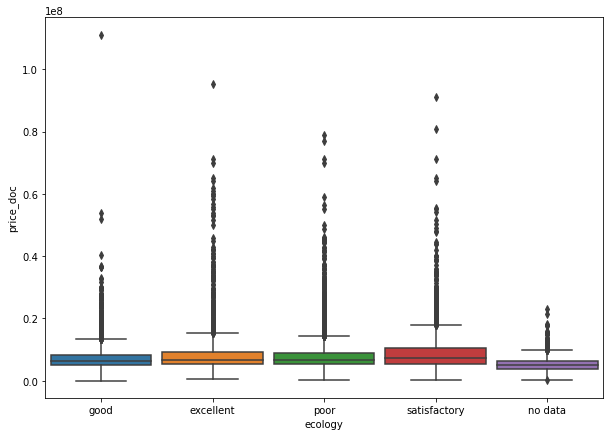

In [155]:
#Постройте коробчатую диаграмму цен на квартиры (price_doc) в зависимости от уровня экологической обстановки
#  в районе (ecology). Какой уровень ценится на рынке меньше всего? 
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=sber_data,
    y='price_doc',
    x='ecology',
    #orient='h',
    width=0.9
)

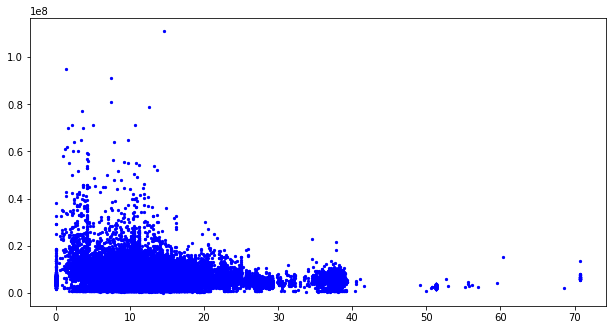

In [156]:
#Постройте диаграмму рассеяния, которая покажет, как цена на квартиру (price_doc) связана
#  с расстоянием до центра Москвы (kremlin_km). Выберите все верные утверждения.

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
s1 = axes.scatter(
    y=sber_data['price_doc'], 
    x=sber_data['kremlin_km'], 
    s=5,
    marker='o',
    c = 'blue'
);


In [157]:
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

hospital_beds_raion          47.392603
preschool_quota              21.948738
school_quota                 21.938893
life_sq                      20.947786
floor                         0.548062
metro_min_walk                0.082045
metro_km_walk                 0.082045
railroad_station_walk_km      0.082045
railroad_station_walk_min     0.082045
dtype: float64

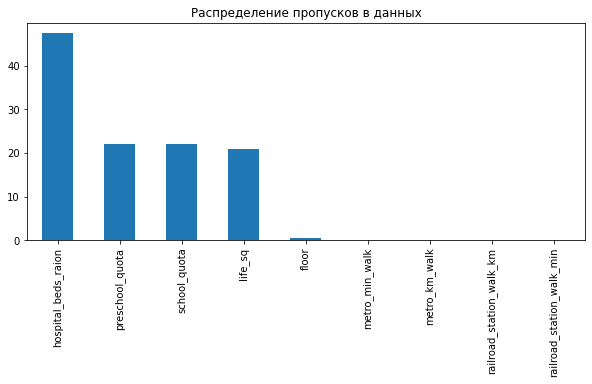

In [158]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

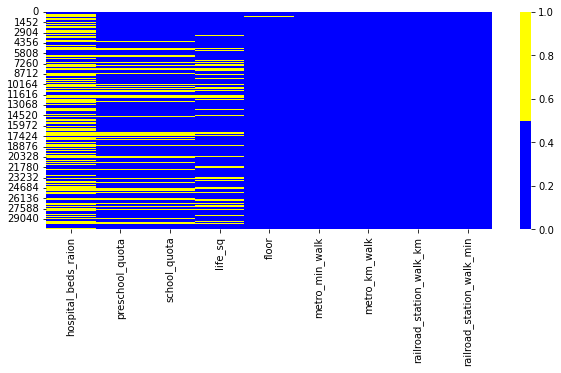

In [159]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    sber_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

In [160]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    """
    Давайте немного модифицируем нашу функцию outliers_iqr(). 
    Добавьте в нее параметры left и right, которые задают число IQR влево и вправо
    от границ ящика (пусть по умолчанию они равны 1.5).
    Функция, как и раньше должна возвращать потенциальные выбросы и очищенный DataFrame.
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [161]:
#Примените модифицированную функцию outliers_iqr_mod() к признаку full_sq из таблицы
#  sber_data данным с параметрами left=1 и right=6. Результаты работы поместите
#  в переменные outliers и cleaned. Чему равно результирующее число выбросов в данных?

outliers, cleaned = outliers_iqr_mod(sber_data, 'full_sq', left=1 ,right=6)

In [162]:
outliers.shape

(59, 61)

In [163]:
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    """
    Давайте расширим правило 3ех сигм, чтобы иметь возможность учитывать особенности данных.
    Добавьте в функцию outliers_z_score() параметры left и right, которые будут задавать число сигм (стандартных отклонений) 
    влево и вправо соответственно, которые определяют границы метода z-отклонения. 
    По умолчанию оба параметры равны 3
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [164]:
# Проверьте, что будет, если дать «послабление» вправо, увеличив число сигм. Наша задача — узнать,
# начиная с какой границы поселения «Роговское» и «Киевское» перестают считаться выбросами.
# Примените свою функцию outliers_z_score_mod() к признаку mkad_km с параметрами left=3, right=3.5,
# log_scale=True. Чему равно результирующее число выбросов?

In [165]:
outliers, cleaned = outliers_z_score_mod(sber_data, 'mkad_km', log_scale=True, left=3, right=3.5)

In [166]:
outliers.shape

(0, 61)

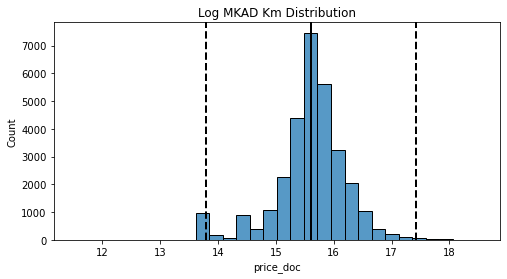

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

In [168]:
#Добавьте фишку с логарифмированием в свою функцию outliers_iqr_mod(). 
# Добавьте в неё параметр log_scale. Если он выставлен в True, то производится логарифмирование признака.
#  Примените полученную функцию к признаку price_doc. Число межквартильных размахов в обе стороны 
# обозначьте как 3. Чему равно число выбросов, полученных таким методом?
# При логарифмировании признака price_doc добавлять к нему 1 не нужно, он не имеет нулевых значений!

outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', left=3 ,right=3, log_scale=True)
outliers.shape

(629, 61)

In [169]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', left=3, right=3, log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')

Число выбросов по методу Тьюки: 92


In [170]:
#Найдите потенциальные выбросы с помощью метода z-отклонения. Используйте логарифмический масштаб распределения. Сделайте «послабление» на 0.7 сигм в в обе стороны распределения.
#  Сколько выбросов вы получили? Воспользуйтесь функцией outliers_z_score_mod()

outliers, cleaned = outliers_z_score_mod(sber_data, 'price_doc', left=3.7, right=3.7, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')

Число выбросов по методу z-отклонения: 52


In [171]:
diabetes = pd.read_csv('data/diabetes_data.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Gender
0,6,98,58,33,190,34.0,0.430,43,0,Female
1,2,112,75,32,0,35.7,0.148,21,0,Female
2,2,108,64,0,0,30.8,0.158,21,0,Female
3,8,107,80,0,0,24.6,0.856,34,0,Female
4,7,136,90,0,0,29.9,0.210,50,0,Female


In [172]:
dupl_columns = list(diabetes.columns)
diabetes_dedupped = diabetes.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {diabetes_dedupped.shape[0]}')

Результирующее число записей: 768


In [173]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in diabetes.columns:
    #наибольшая относительная частота в признаке
    top_freq = diabetes[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = diabetes[col].nunique() / diabetes[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

Gender: 100.0% одинаковых значений


In [174]:
diabetes.drop('Gender', axis=1, inplace=True)

In [175]:
#Замените все записи, равные 0, в столбцах
#  Glucose, BloodPressure, SkinThickness, Insulin и BMI на символ пропуска.
#  Его вы можете взять из библиотеки numpy: np.nan.
# Какая доля пропусков содержится в столбце Insulin? Ответ округлите до сотых.

def fill_by_nan(value):
    if value == 0: return np.nan
    else: return value

columns_to_check  = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']  
for col in columns_to_check:
    diabetes[col] = diabetes[col].apply(fill_by_nan)


In [176]:
diabetes['Insulin'].isnull().sum()/diabetes.shape[0]

0.4884318766066838

In [177]:
for col in diabetes.columns:
    print(col, diabetes[col].isnull().sum()/diabetes.shape[0])

Pregnancies 0.0
Glucose 0.006426735218508998
BloodPressure 0.04627249357326478
SkinThickness 0.2982005141388175
Insulin 0.4884318766066838
BMI 0.014138817480719794
DiabetesPedigreeFunction 0.0
Age 0.0
Outcome 0.0


In [178]:
diabetes.drop('Insulin', axis=1, inplace=True)

In [179]:
diabetes.shape

(778, 8)

In [180]:
m = diabetes.shape[1]
diabetes = diabetes.dropna(thresh=m-2, axis=0)
print(diabetes.shape[0])

771


In [181]:
diabetes.shape

(771, 8)

In [183]:
null_data = diabetes.isnull().sum()
cols = null_data[null_data>0].index
for col in cols:
    diabetes[col] = diabetes[col].fillna(diabetes[col].median())
print(diabetes['SkinThickness'].mean())

29.106355382619974


In [184]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned
outliers, _ = outliers_iqr_mod(diabetes, 'SkinThickness')
print(outliers.shape[0])

87
